In [73]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds

from sklift.models import SoloModel
from sklift.models import ClassTransformation
from sklift.models import TwoModels

from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

from catboost import CatBoostClassifier


from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')


In [9]:
df = pd.read_csv('/content/sample_data/HW_data.csv', sep=',')

In [11]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [13]:
df.rename(columns={'conversion':'target', 'offer':'treatment'},inplace=True)

In [14]:
df['recency'] = df['recency'].astype('object')

In [15]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [16]:
df['treatment'] = df['treatment'].map({'Buy One Get One':1,
                    'Discount': 1,
                    'No Offer':0})

In [18]:
X_train,X_val = train_test_split(df, test_size=0.3, random_state=42)

In [19]:
X_train.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
9656,7,434.35,1,0,Urban,1,Web,0,0
63037,1,376.59,1,0,Surburban,0,Multichannel,1,0
31405,3,140.34,0,1,Urban,1,Phone,1,1
58088,3,150.76,0,1,Surburban,0,Web,0,0
44344,2,67.97,1,0,Surburban,1,Phone,1,0


In [20]:
y_train = X_train['target']
treat_train=X_train['treatment']
X_train = X_train.drop(columns=['target','treatment'])

y_val = X_val['target']
treat_val = X_val['treatment']
X_val = X_val.drop(columns=['target','treatment'])

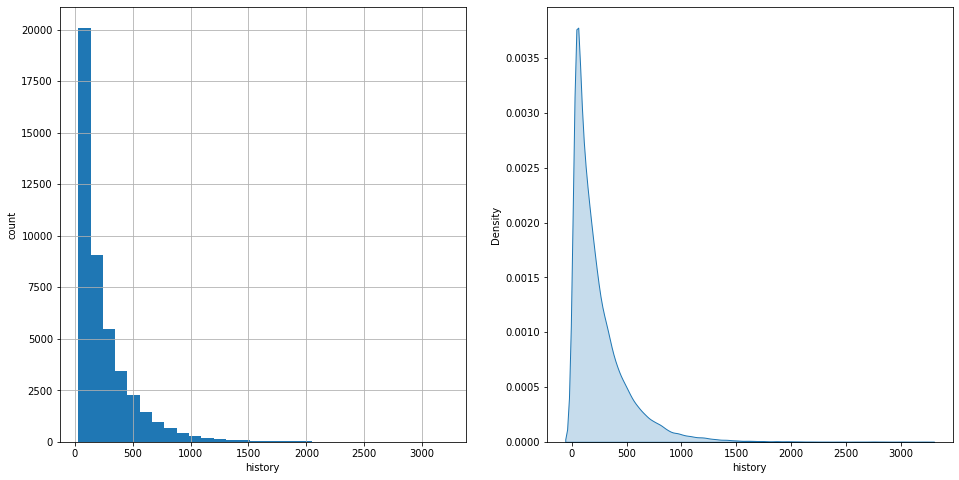

In [21]:
plt.figure(figsize=(16,8))

plt.subplot(121)
X_train['history'].hist(density=False, bins=30)
plt.ylabel('count')
plt.xlabel('history')

plt.subplot(122)
sns.kdeplot(X_train['history'],shade=True, legend=False)
plt.xlabel('history')

plt.show()

In [22]:
X_train['channel'].value_counts()

Web             19772
Phone           19635
Multichannel     5393
Name: channel, dtype: int64

In [23]:
X_train['zip_code'].value_counts()

Surburban    20274
Urban        17824
Rural         6702
Name: zip_code, dtype: int64

In [24]:
class ColumnSelector(BaseEstimator,TransformerMixin):
    
    def __init__(self,key):
        self.key = key
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[[self.key]]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, key):
        self.key = key
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[[self.key]]

class OHEEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self,key):
        self.key = key
        self.columns = []
        
    
    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix = self.key).columns]
        return self
    
    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        add_columns = [col for col in X.columns]
        for col in add_columns:
            if col not in self.columns:
                X[col] = 0
        return X[self.columns]

quant_col = ['history']
qual_col = ['channel', 'zip_code', 'recency']
base_col = ['used_discount', 'used_bogo', 'is_referral']

quant_transformers = []
qual_transformers = []
base_transformers = []

quant_trasnsformer = Pipeline([('selector', NumberSelector(key=quant_col[0])),
                               ('standard', StandardScaler())])
quant_transformers.append((quant_col[0], quant_trasnsformer))

for col in qual_col:
    qual_transformer = Pipeline([
        ('selector', ColumnSelector(key=col)),
        ('ohe', OHEEncoder(key=col))
    ])
    qual_transformers.append((col,qual_transformer))
    
for col in base_col:
    base_transformer = Pipeline([
        ('selector', NumberSelector(key=col))
    ])
    base_transformers.append((col, base_transformer))

models_results = {
    'approach': [],
    'uplift@30%': []
}   

In [25]:
features = FeatureUnion(quant_transformers + base_transformers + qual_transformers)

In [26]:
features

FeatureUnion(transformer_list=[('history',
                                Pipeline(steps=[('selector',
                                                 NumberSelector(key='history')),
                                                ('standard',
                                                 StandardScaler())])),
                               ('used_discount',
                                Pipeline(steps=[('selector',
                                                 NumberSelector(key='used_discount'))])),
                               ('used_bogo',
                                Pipeline(steps=[('selector',
                                                 NumberSelector(key='used_bogo'))])),
                               ('is_referral',
                                Pipeline(steps=[('selector',
                                                 NumberSelector(key='is_referral'))])),
                               ('channel',
                                Pipeline(steps=[('se

## Solomodel

In [27]:
features_processing = Pipeline([('features',features)])

X_train = features_processing.fit_transform(X_train)
X_val = features_processing.fit_transform(X_val)

In [75]:
X_train[0].shape

(22,)

In [29]:
Solo_model = SoloModel(CatBoostClassifier(iterations=20, thread_count=2,random_state=42,silent=True))

In [30]:
Solo_model = Solo_model.fit(X_train, y_train, treat_train)

In [31]:
uplift_sm = Solo_model.predict(X_val)

In [32]:
sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)

In [33]:
models_results['approach'].append('Solomodel')
models_results['uplift@30%'].append(sm_score)


In [34]:
sm_trmnt_preds = Solo_model.trmnt_preds_
sm_ctrl_preds = Solo_model.ctrl_preds_

<Figure size 1152x576 with 0 Axes>

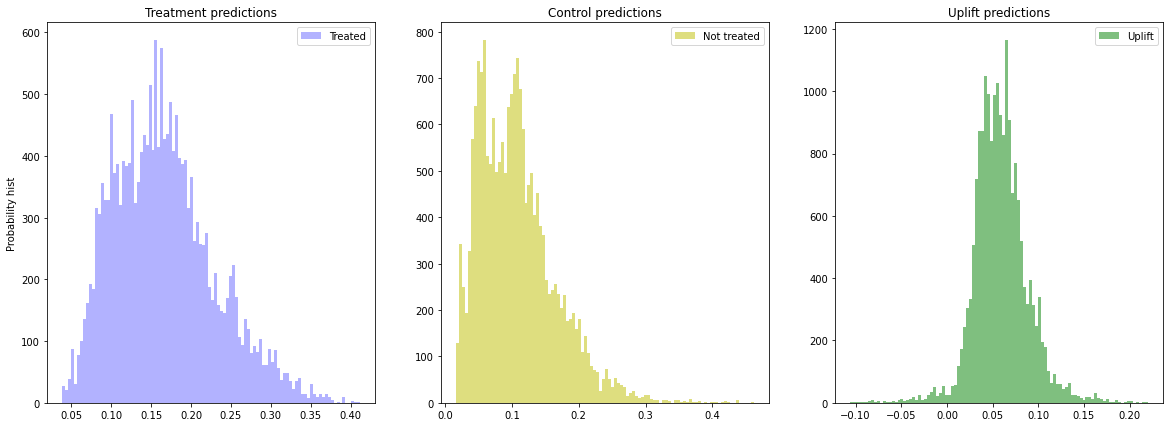

In [35]:
plt.figure(figsize=(16,8))
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds)
plt.show()

# Transformation

In [36]:
class_t = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))


In [37]:
class_t = class_t.fit(X_train,y_train,treat_train)

uplift_ct = class_t.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

In [38]:
models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

## TwoModels

In [39]:
two_models = TwoModels(estimator_trmnt=CatBoostClassifier(iterations=20,thread_count=2, random_state=42,silent=True),
                       estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True),
                       method='vanilla'
                      )

In [40]:
two_models = two_models.fit(X_train, y_train, treat_train)

In [41]:
uplift_tm = two_models.predict(X_val)

In [42]:
tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

In [43]:
models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

<Figure size 1152x576 with 0 Axes>

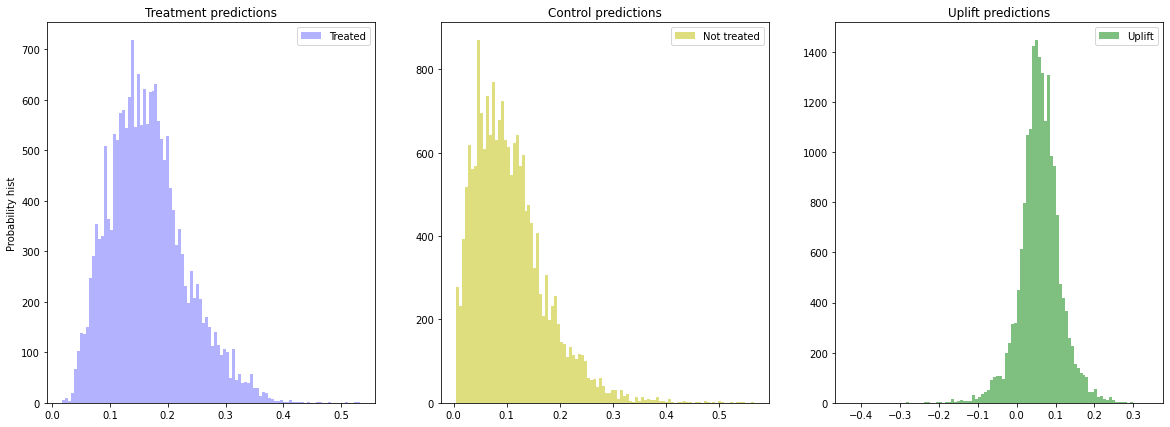

In [44]:
plt.figure(figsize=(16,8))
plot_uplift_preds(trmnt_preds=two_models.trmnt_preds_, ctrl_preds=two_models.ctrl_preds_)
plt.show()

In [83]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
0,Solomodel,0.085067
1,ClassTransformation,0.079209
2,TwoModels,0.071978


## Tree

In [77]:
features = ['history', 'used_discount', 'used_bogo', 'is_referral', 'channel_Multichannel', 'channel_Phone', 'channel_Web', 'zip_code_Rural', 
            'zip_code_Surburban', 'zip_code_Urban','recency_1', 'recency_2', 'recency_3', 'recency_4', 'recency_5',
       'recency_6', 'recency_7', 'recency_8', 'recency_9', 'recency_10',
       'recency_11', 'recency_12']


In [52]:
tree_model = UpliftTreeClassifier(max_depth=8,min_samples_leaf=200, min_samples_treatment=50,
                                  n_reg=100, evaluationFunction='KL', control_name='control')

In [56]:
tree_model.fit(X_train, treatment=treat_train.map({1:'treatment', 0:'control'}).values, y=y_train)

In [80]:
g_tree = uplift_tree_plot(tree_model.fitted_uplift_tree, features)
Image(g_tree.create_png())

Output hidden; open in https://colab.research.google.com to view.

Наиболее важным признаком, по которому совершилось основное деление являеся used_discount(использованная скидка), далее по делению recency можно увидеть что на recency_2 uplift_score пересекает порог меньше 0.1 с не очень стабильным p-value, однако же в целом можно говорить что по  пользователям в данной ветке оттока не будет

Во второй ветке true наиболее значительным является деление по параметрам history, где благонадежными клиентами по history есть клиенты с history > 0.07, 
значение history<-0.78 определяет отточных клиентов